**CS14_cortex**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.21.1 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/CS14_02_20240208_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/CS14_cortex/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-CS14_cortex-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 1419 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


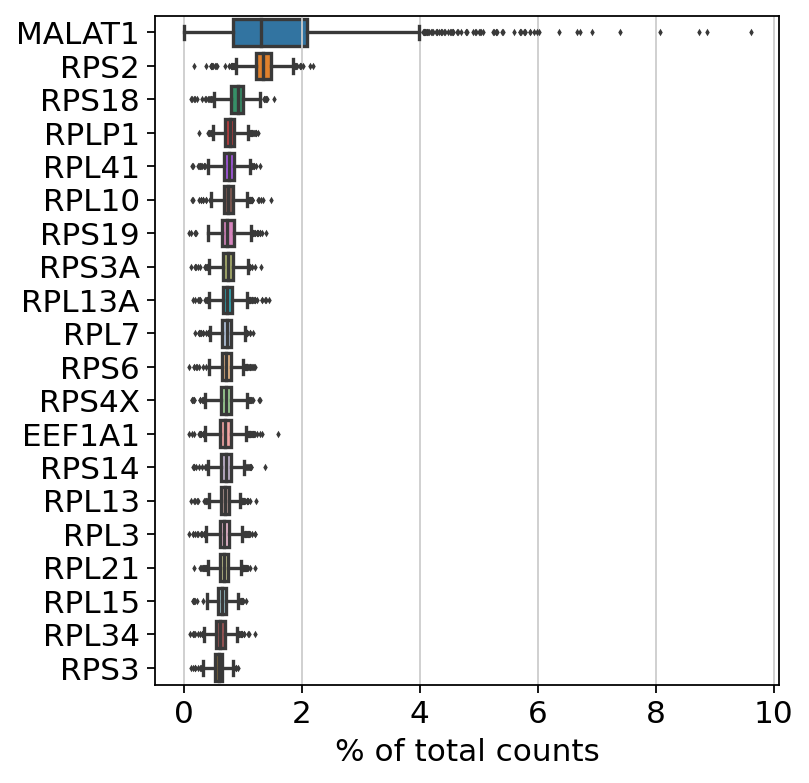

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 22200 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

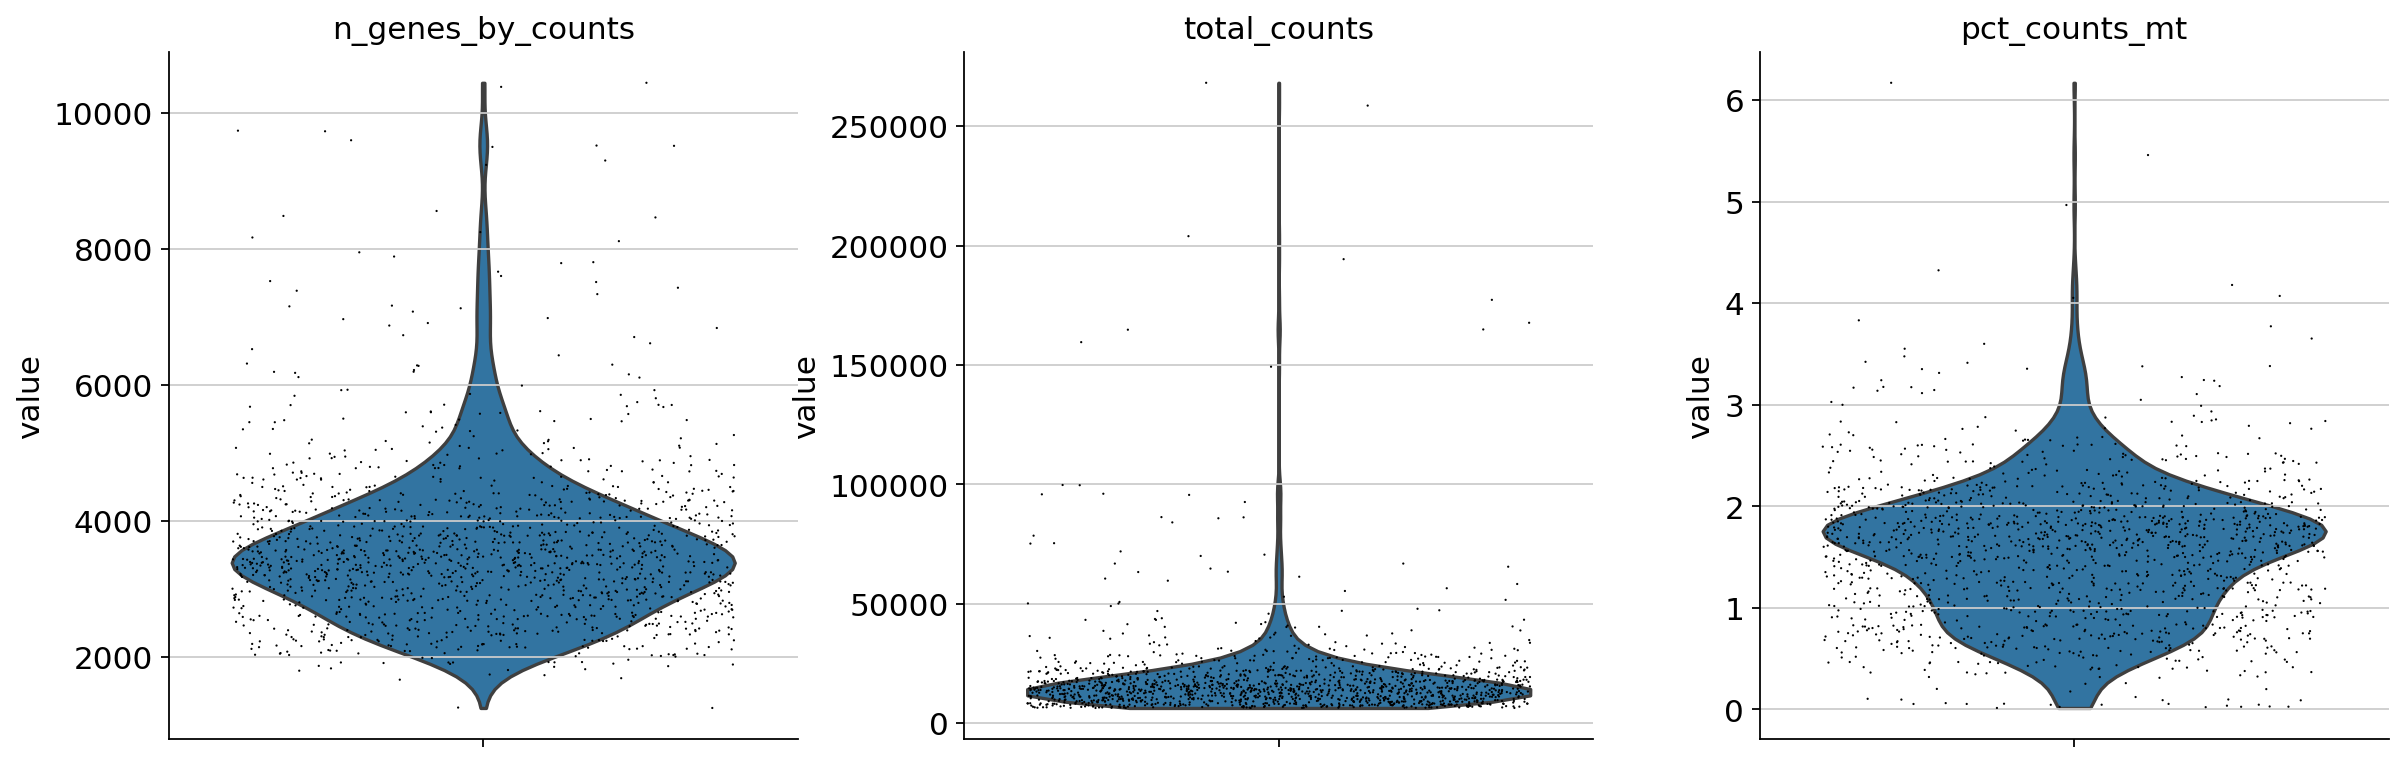

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

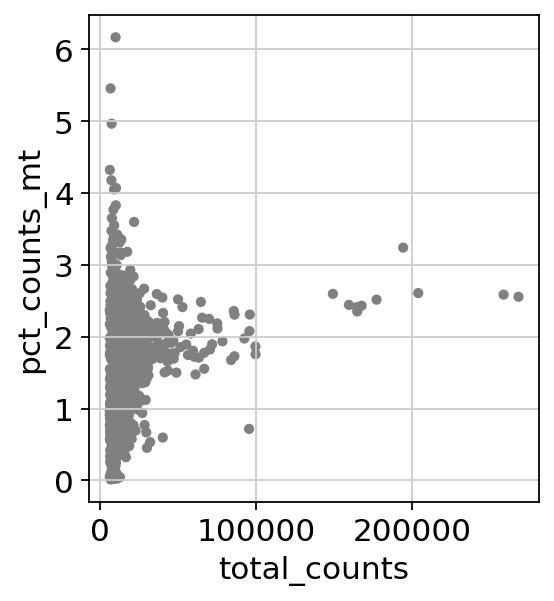

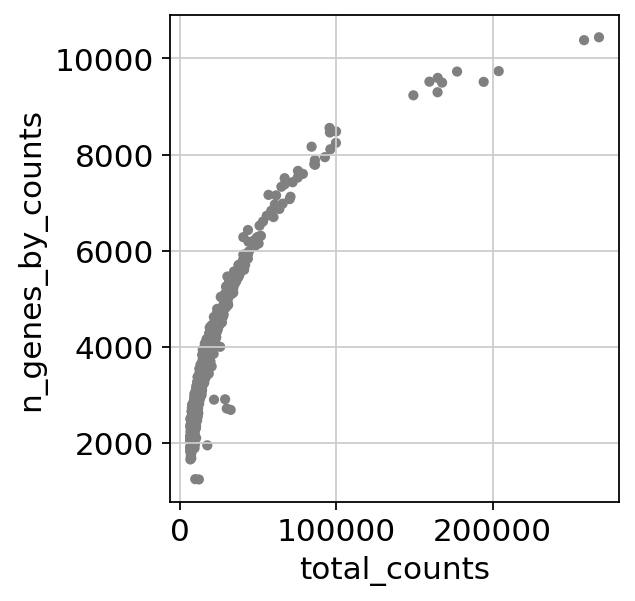

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 50000]

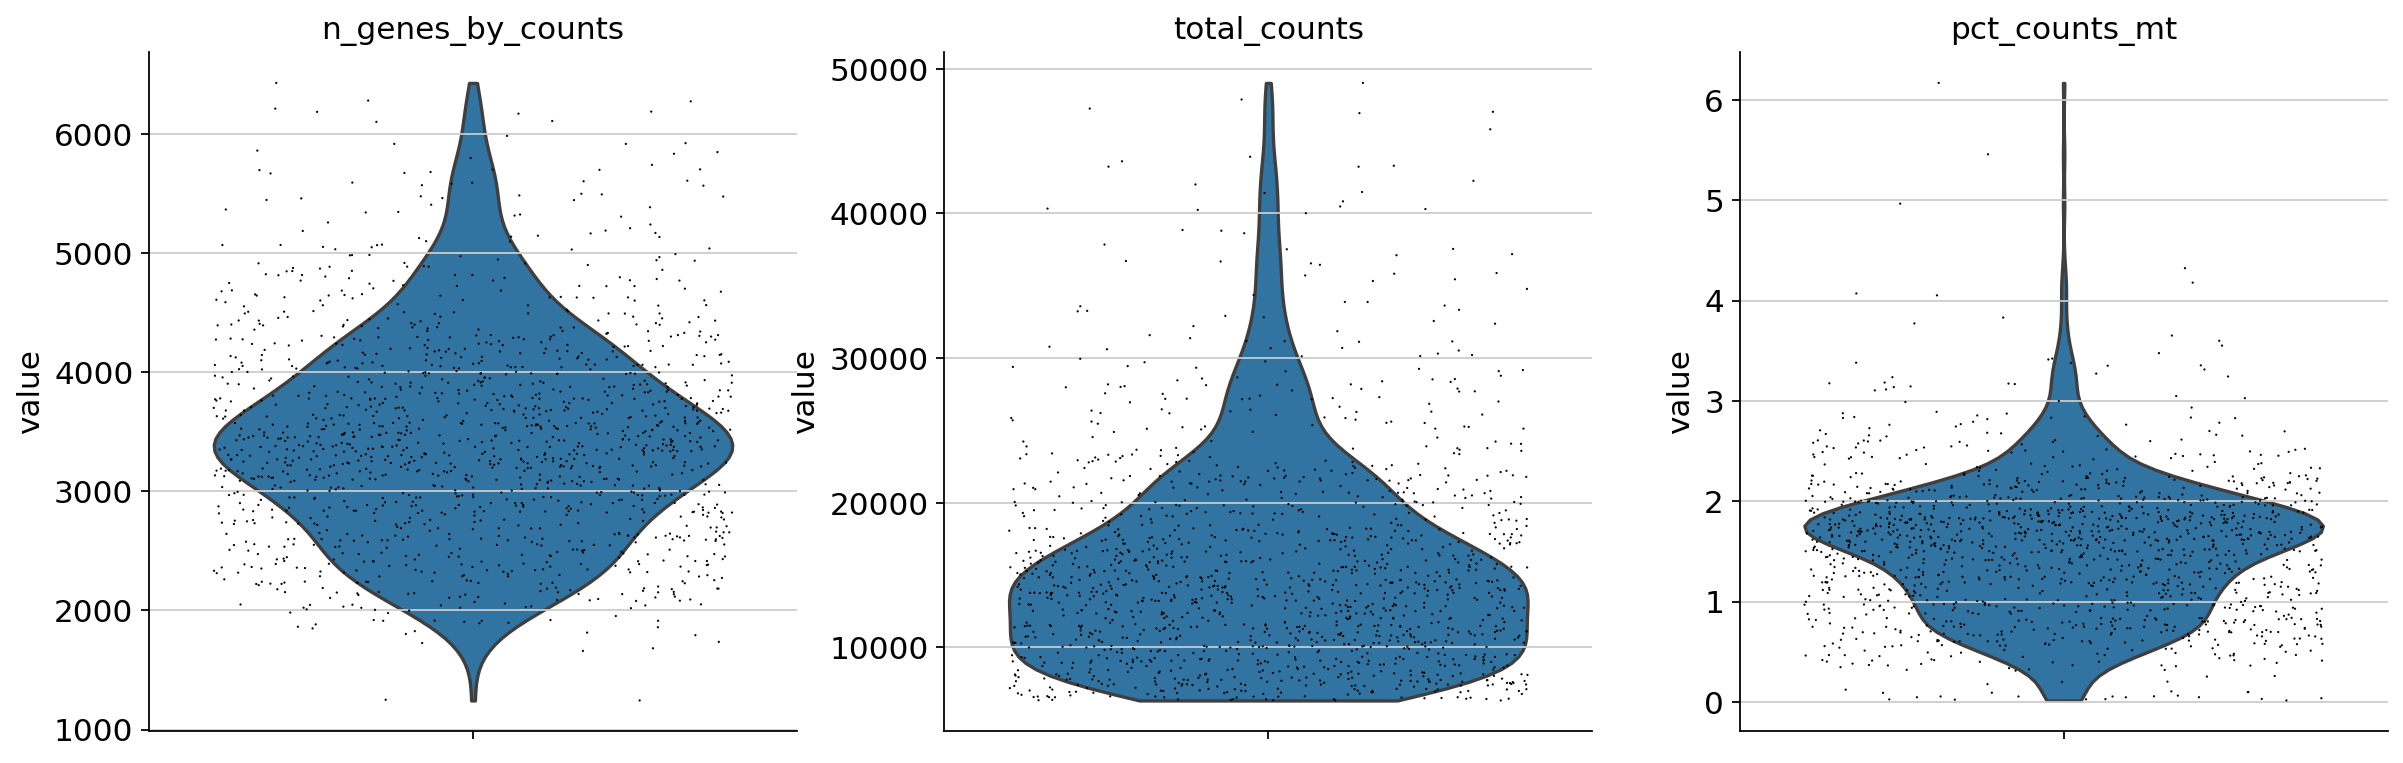

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'S_score', score of gene set (adata.obs).
    556 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    509 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'S_score', 'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G1     803
G2M    327
S      246
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 29.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.0%
    Scrublet finished (0:00:02)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    1372
True        4
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=5e4) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 1376 × 11494
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


Index(['RSPO2', 'SIX6', 'PIF1', 'DIO3', 'TBX3', 'FGF17', 'DLX5', 'C1orf61',
       'NRN1', 'HTR3B', 'SOX2', 'PGF', 'PLK1', 'HES4', 'TFAP2B', 'TBX2-AS1',
       'FILIP1', 'TTYH1', 'LHX2', 'TNFAIP6'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['FO538757.2', 'AP006222.2', 'RP11-206L10.9', 'LINC00115', 'NOC2L',
       'KLHL17', 'HES4', 'ISG15', 'AGRN', 'C1orf159',
       ...
       'PCNT', 'DIP2A', 'PRMT2', 'MT-ND1', 'MT-ATP8', 'MT-ND3', 'MT-ND4L',
       'MT-ND6', 'AC011043.1', 'AC240274.1'],
      dtype='object', length=11436)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


... storing 'phase' as categorical


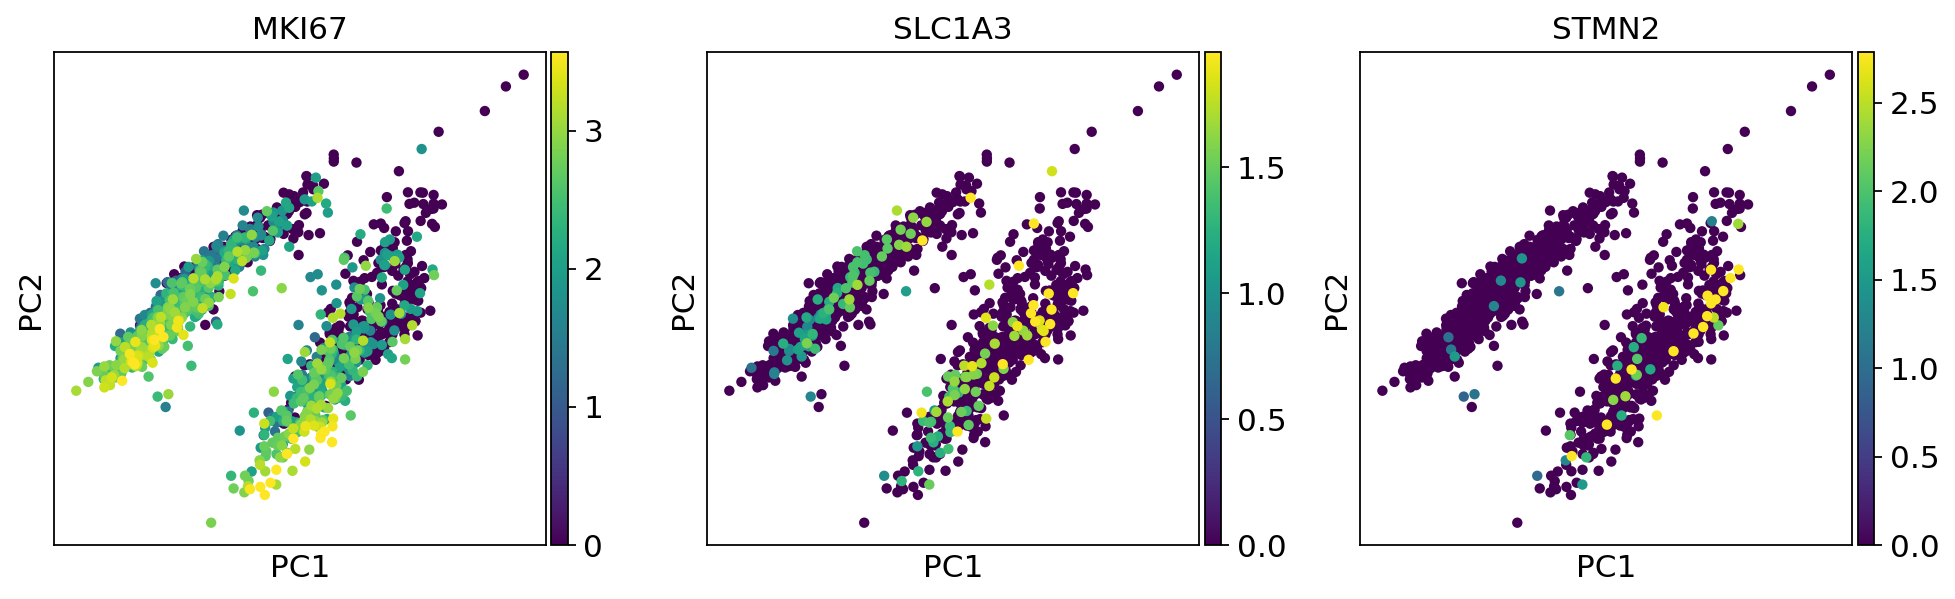

In [25]:
# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") 

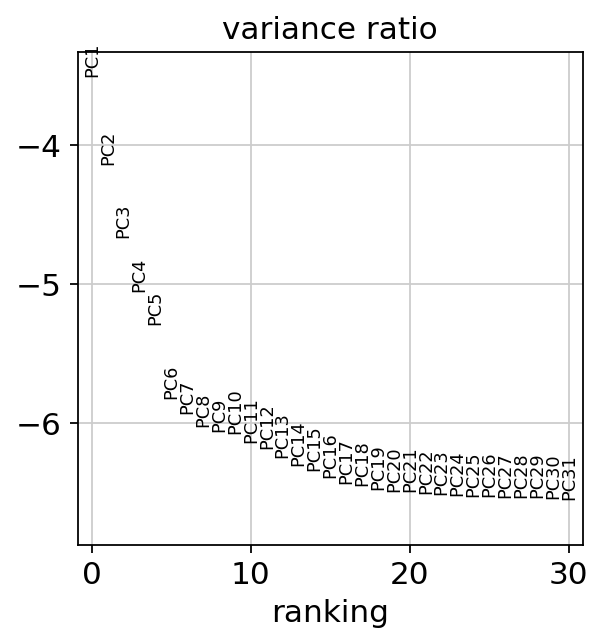

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
# saving the result
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 1376 × 11494
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

18

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [32]:
adata.obs.leiden.value_counts()

0    303
1    255
2    232
3    207
4    130
5    111
6    100
7     38
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


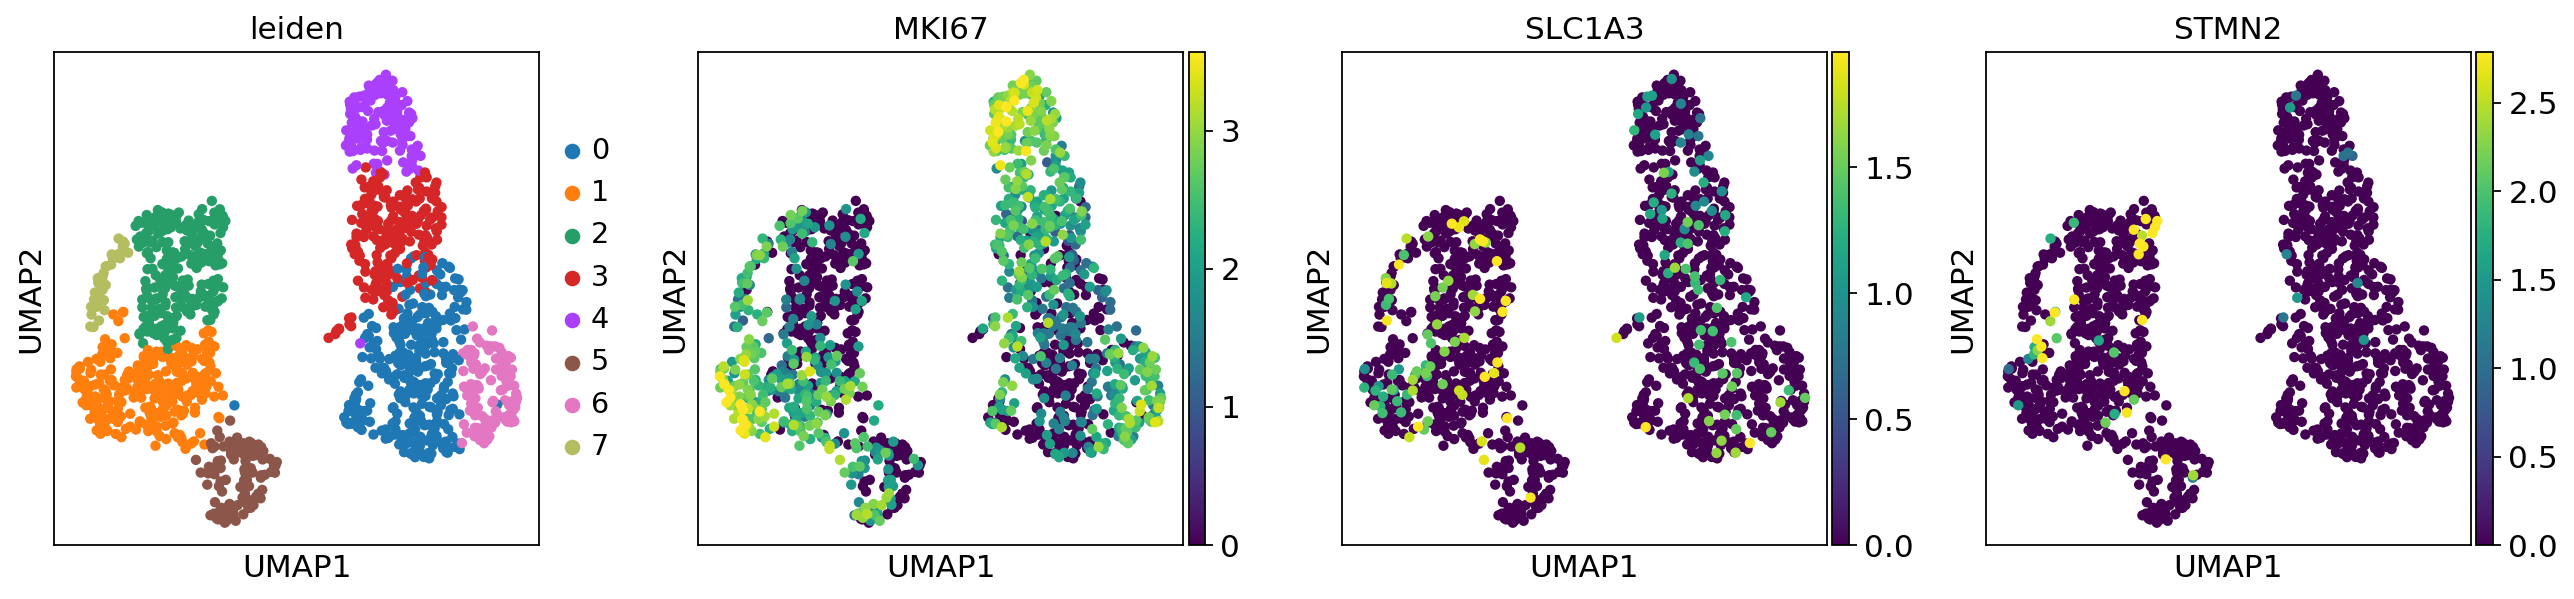

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

In [36]:
# Plot the clusters, which agree quite well with the result of Seurat.
# sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'])

In [37]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


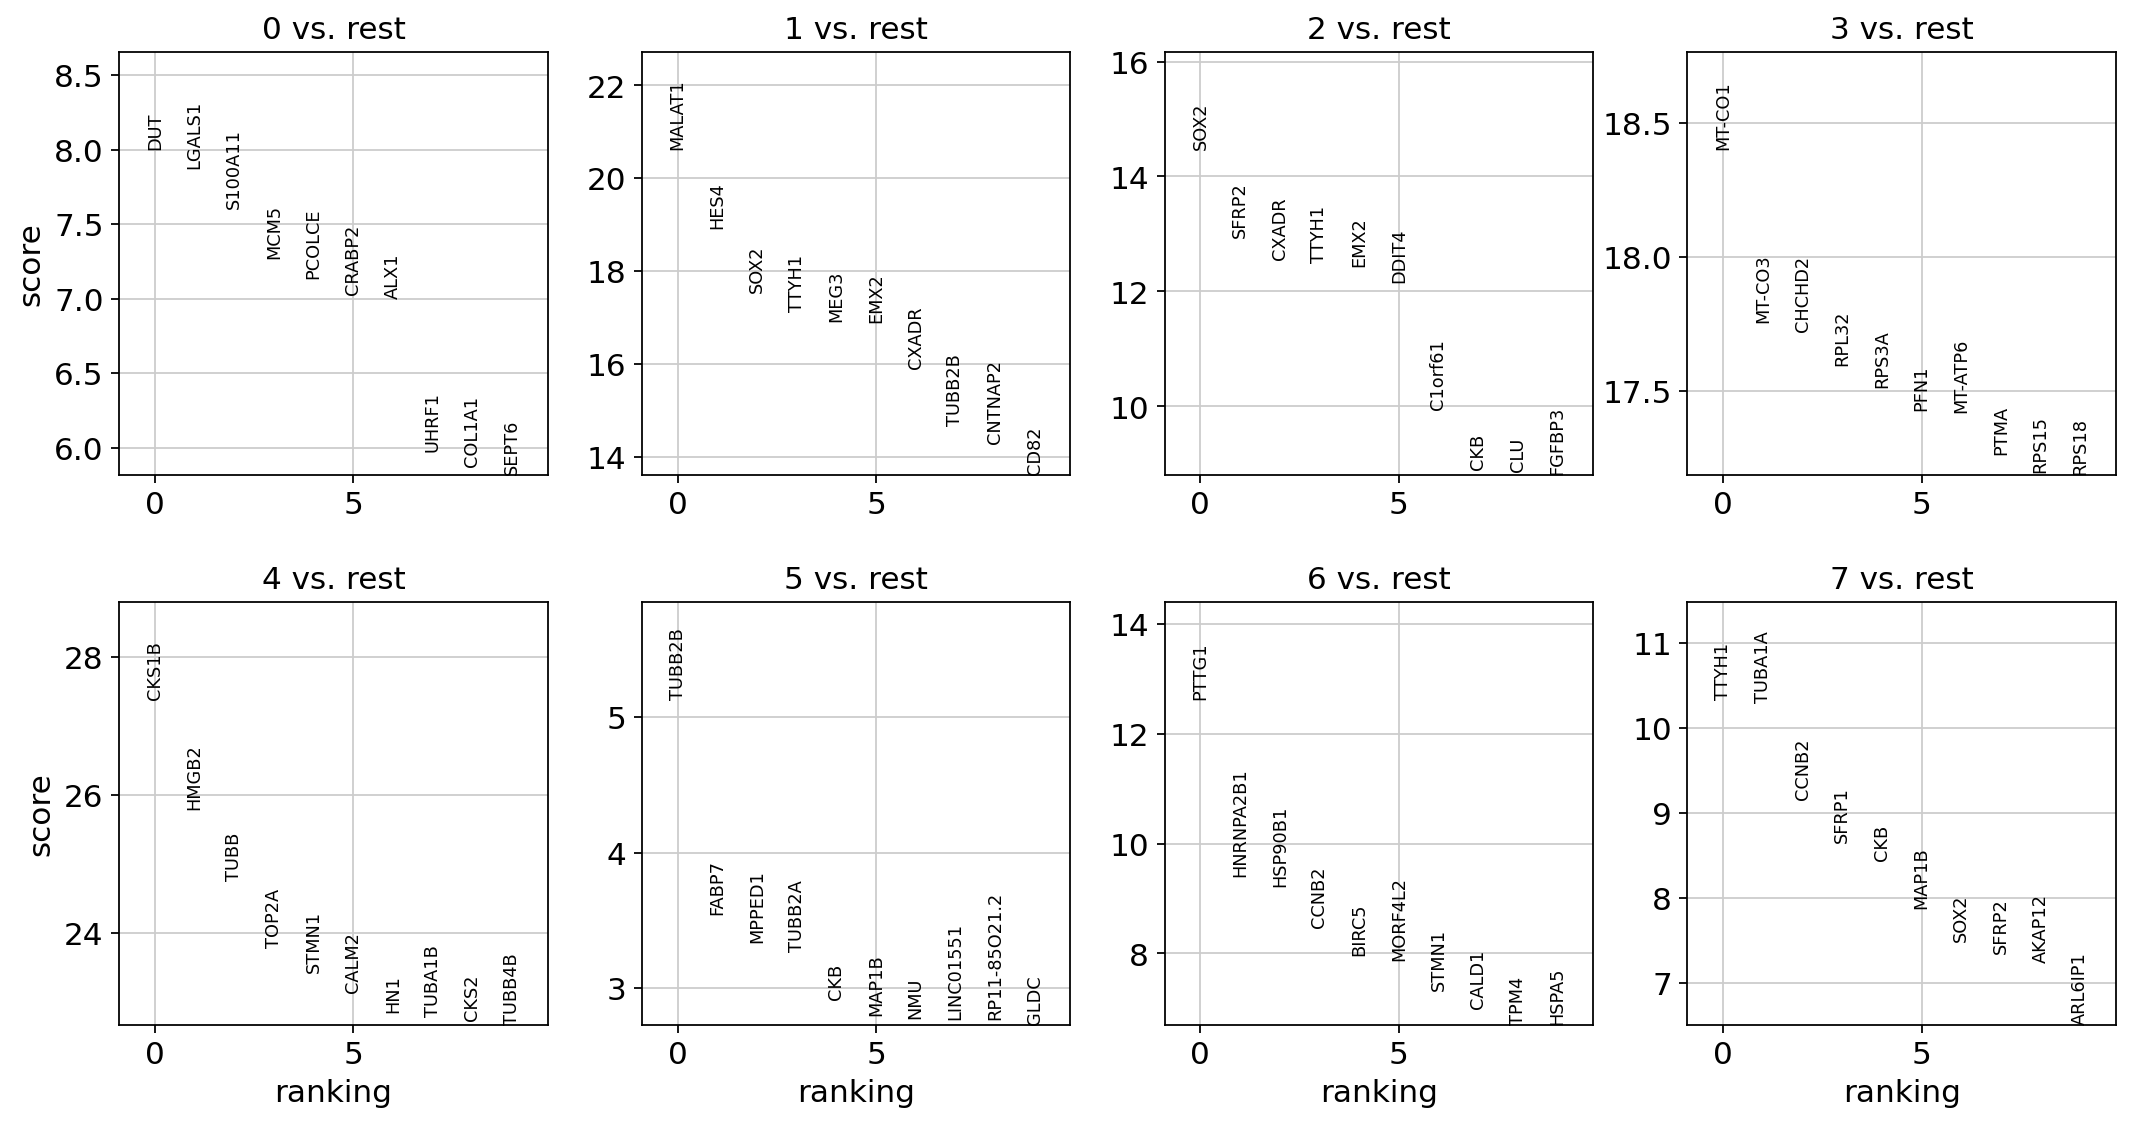

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [39]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p     1_n           1_p    2_n           2_p     3_n  \
0      DUT  8.769118e-15  MALAT1  2.448076e-60   SOX2  9.247293e-39  MT-CO1   
1   LGALS1  1.963561e-14    HES4  6.331622e-52  SFRP2  9.906967e-31  MT-CO3   
2  S100A11  1.691389e-13    SOX2  1.096510e-47  CXADR  5.931685e-30  CHCHD2   
3     MCM5  1.543164e-12   TTYH1  1.927513e-46  TTYH1  2.594726e-30   RPL32   
4   PCOLCE  2.740595e-12    MEG3  1.015649e-44   EMX2  8.686310e-30   RPS3A   

            3_p    4_n           4_p     5_n           5_p        6_n  \
0  1.578515e-51  CKS1B  6.590491e-59  TUBB2B  9.784172e-07      PTTG1   
1  4.671440e-49  HMGB2  1.801470e-56   FABP7  5.551338e-04  HNRNPA2B1   
2  1.974889e-47   TUBB  3.185510e-55  MPPED1  1.152993e-03    HSP90B1   
3  8.131244e-47  TOP2A  9.151282e-51  TUBB2A  1.375557e-03      CCNB2   
4  6.707598e-47  STMN1  2.570407e-52     CKB  4.155639e-03      BIRC5   

            6_p     7_n           7_p  
0  1.333011e-24   TTYH1  6.764653e-13  
1  1.266374e-16  TUBA1A  2.690545e-13  
2  7.362839e-16   CCNB2  1.676550e-11  
3  3.991413e-14   SFRP1  1.580653e-10  
4  6.149369e-13     CKB  2.316112e-10

In [40]:
adata.write(results_file)

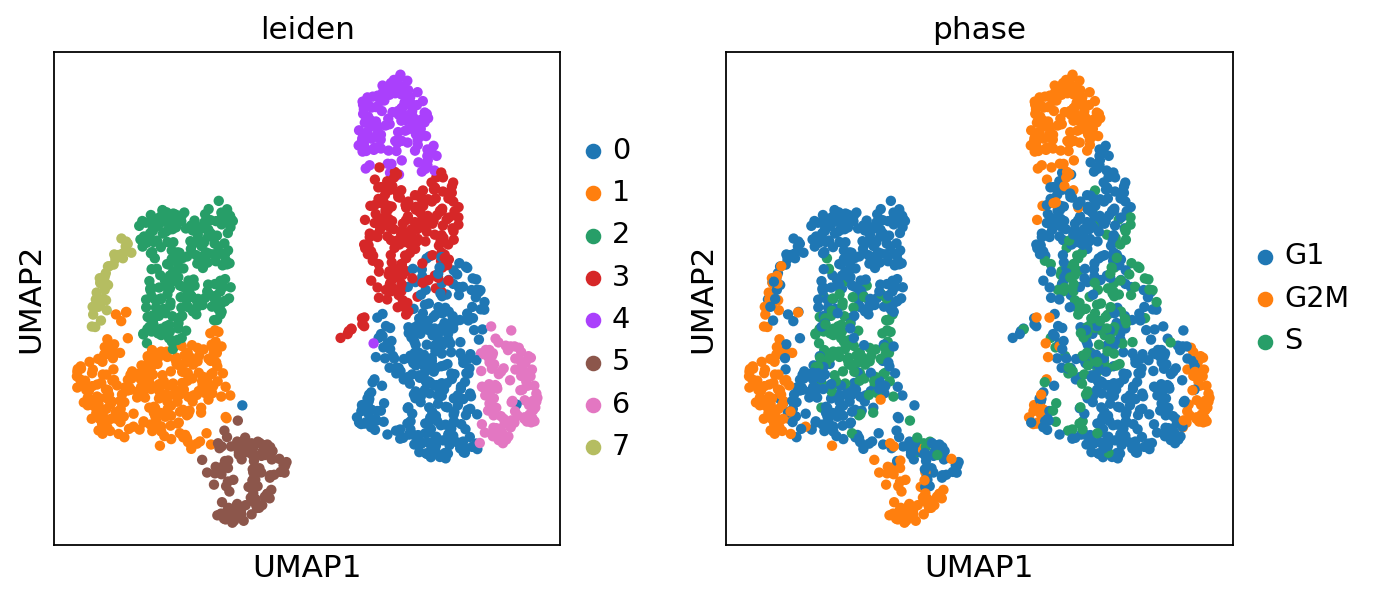

In [41]:
sc.pl.umap(adata,color=["leiden","phase"])

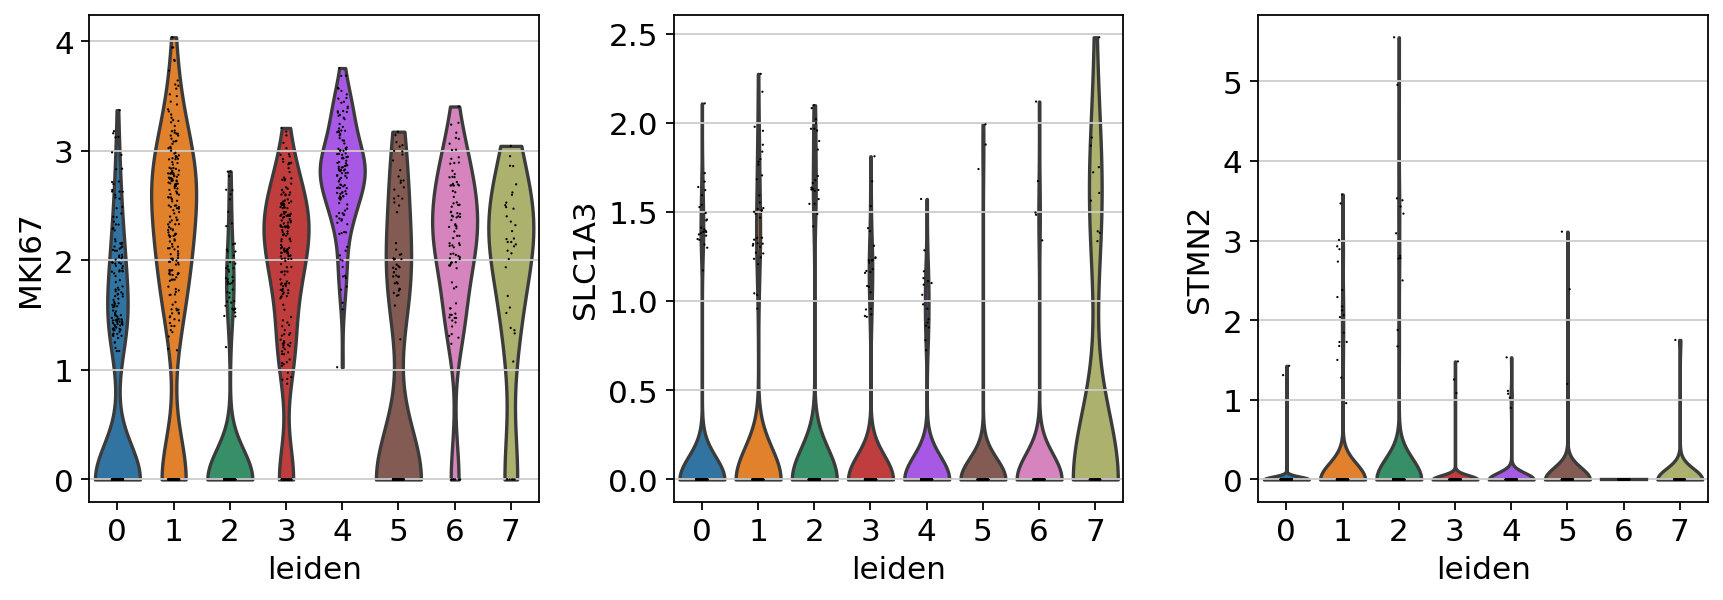

In [42]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1        2        3       4             5          6  \
0      DUT   MALAT1     SOX2   MT-CO1   CKS1B        TUBB2B      PTTG1   
1   LGALS1     HES4    SFRP2   MT-CO3   HMGB2         FABP7  HNRNPA2B1   
2  S100A11     SOX2    CXADR   CHCHD2    TUBB        MPPED1    HSP90B1   
3     MCM5    TTYH1    TTYH1    RPL32   TOP2A        TUBB2A      CCNB2   
4   PCOLCE     MEG3     EMX2    RPS3A   STMN1           CKB      BIRC5   
5   CRABP2     EMX2    DDIT4     PFN1   CALM2         MAP1B    MORF4L2   
6     ALX1    CXADR  C1orf61  MT-ATP6     HN1           NMU      STMN1   
7    UHRF1   TUBB2B      CKB     PTMA  TUBA1B     LINC01551      CALD1   
8   COL1A1  CNTNAP2      CLU    RPS15    CKS2  RP11-85O21.2       TPM4   
9    SEPT6     CD82   FGFBP3    RPS18  TUBB4B          GLDC      HSPA5   

         7  
0    TTYH1  
1   TUBA1A  
2    CCNB2  
3    SFRP1  
4      CKB  
5    MAP1B  
6     SOX2  
7    SFRP2  
8   AKAP12  
9  ARL6IP1

In [44]:
marker_genes = ['leiden', 'ACTB', 'NPM1','TMSB10','GAPDH','EMX2','UBE2C','KPNA2','HBE1','HBZ','ID3','TUBA1A','RPS27', 'EEF1A1']

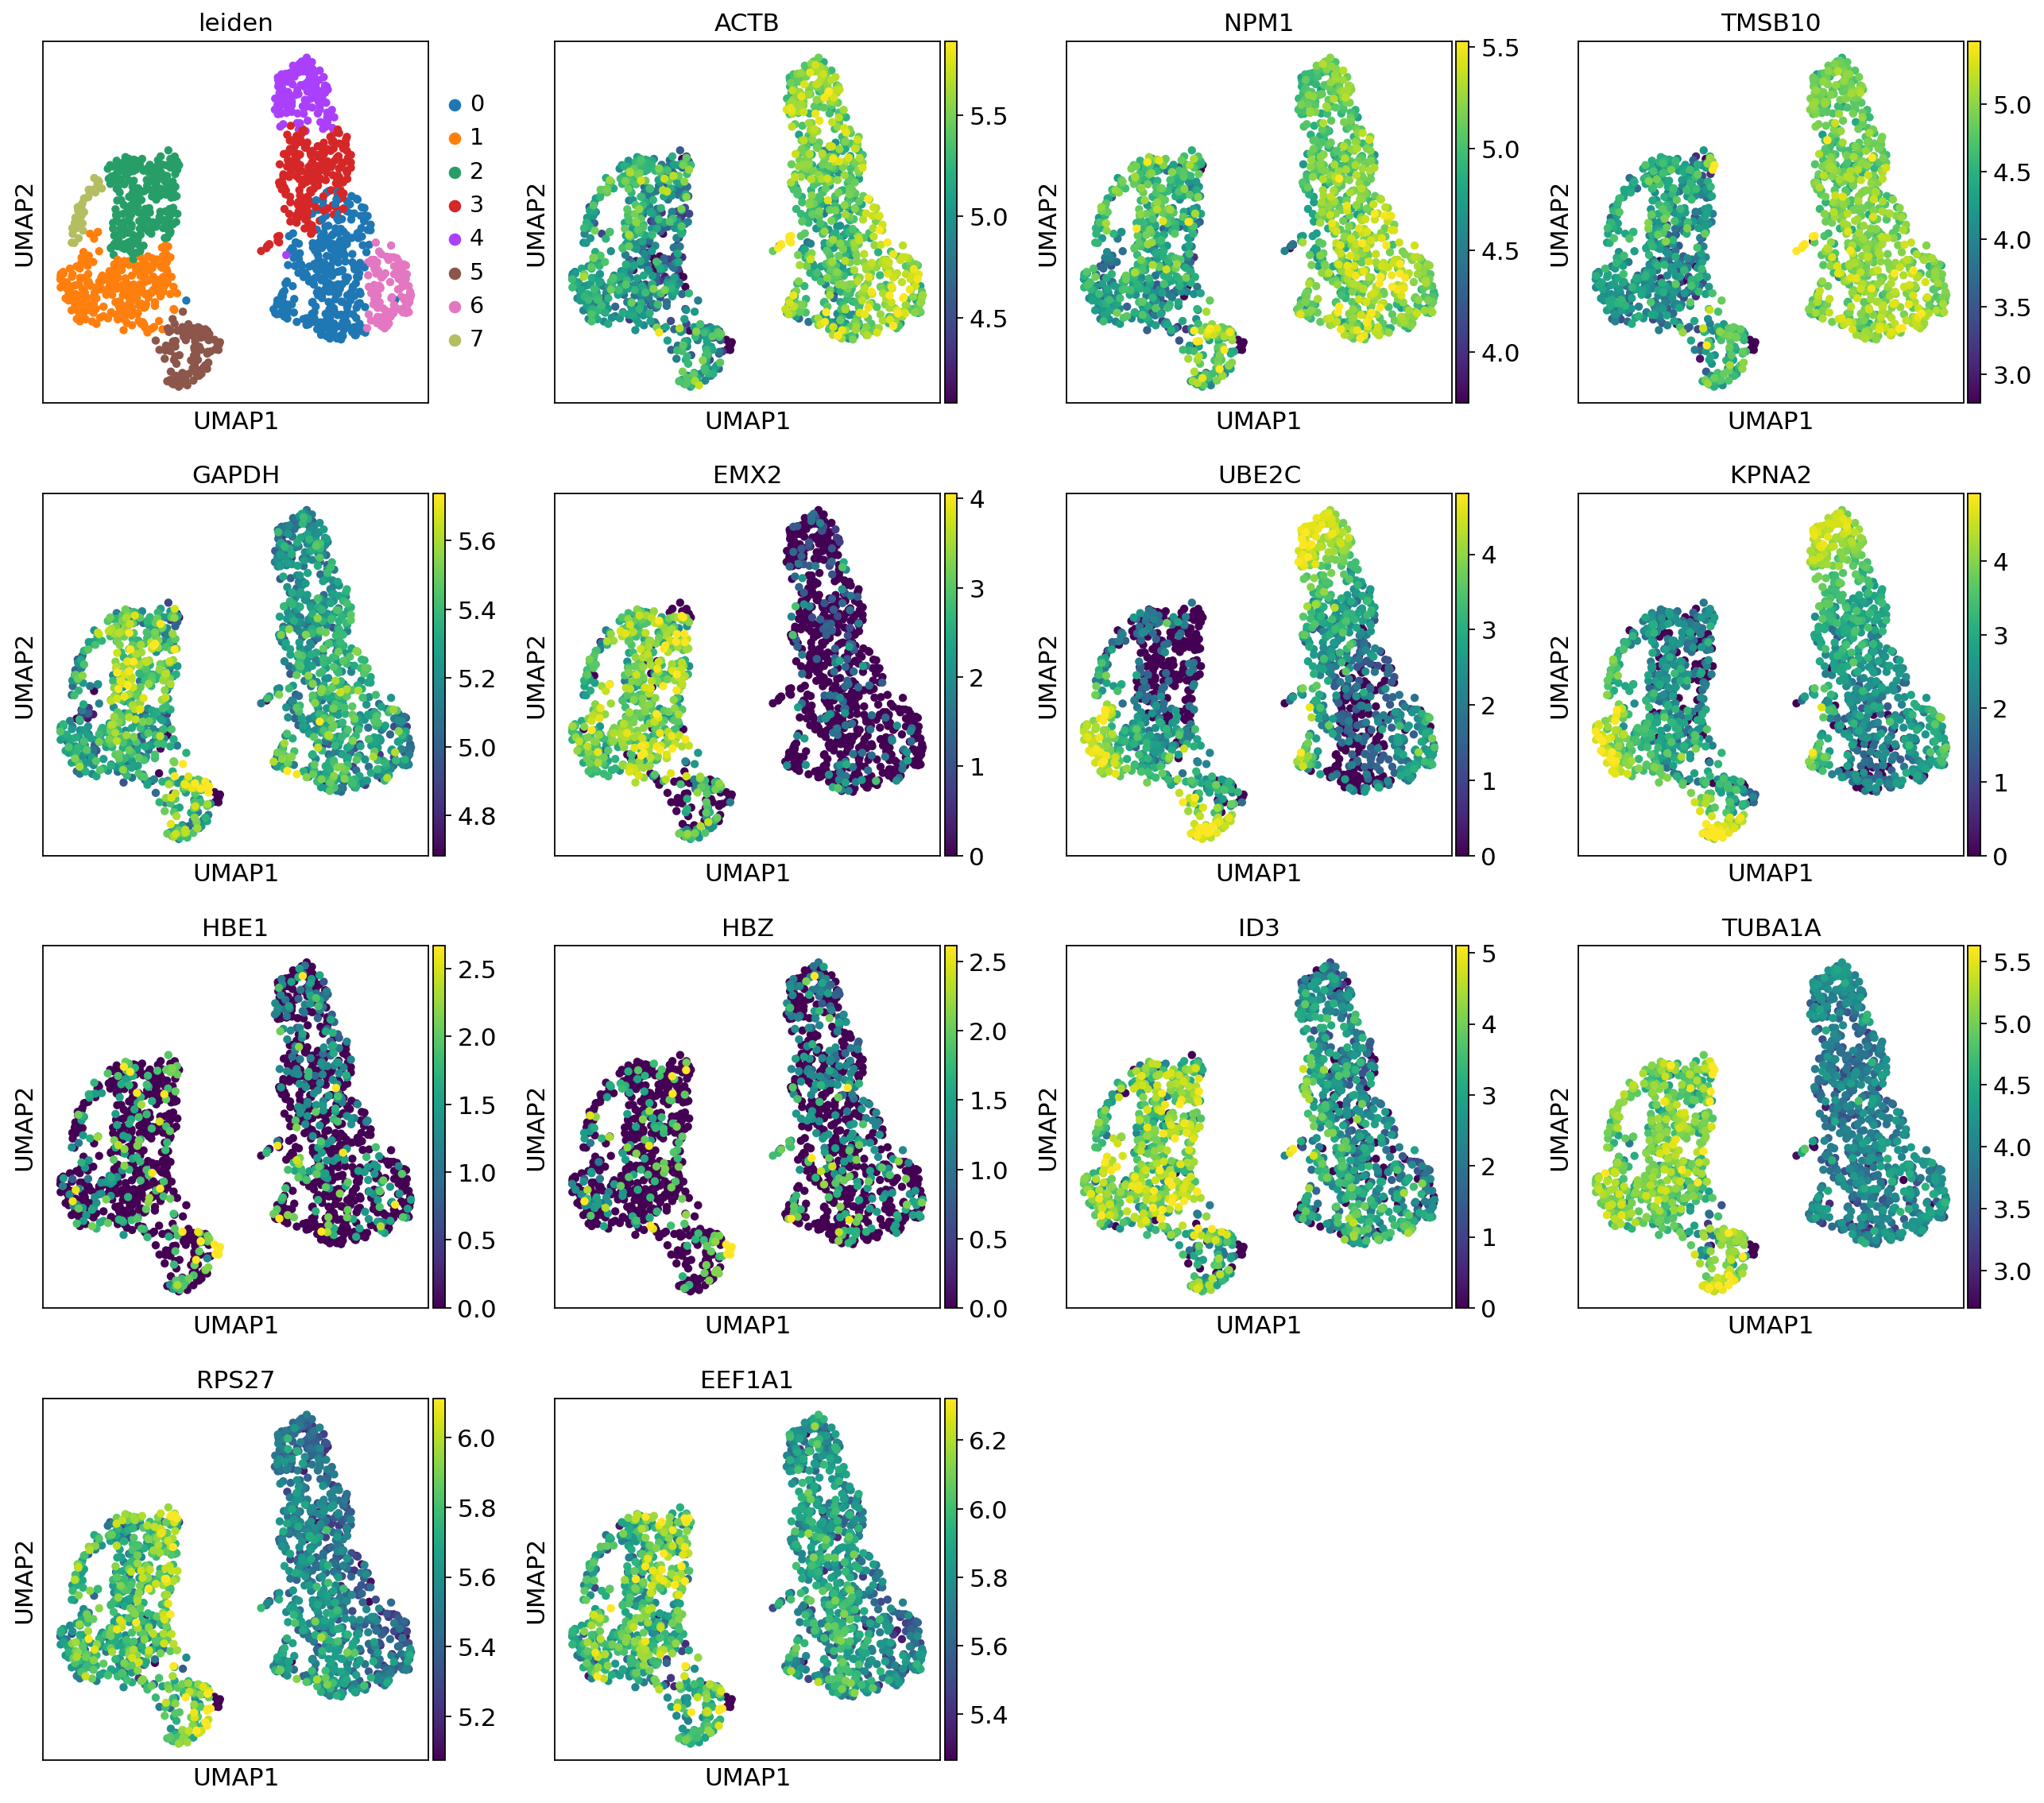

In [45]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [46]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99682534 0.9754985  0.9712987  0.9617903  0.9532212
     0.9356672  0.93128043 0.9228877  0.91909087 0.9044036  0.89440185
     0.8914522  0.888701   0.8837802 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


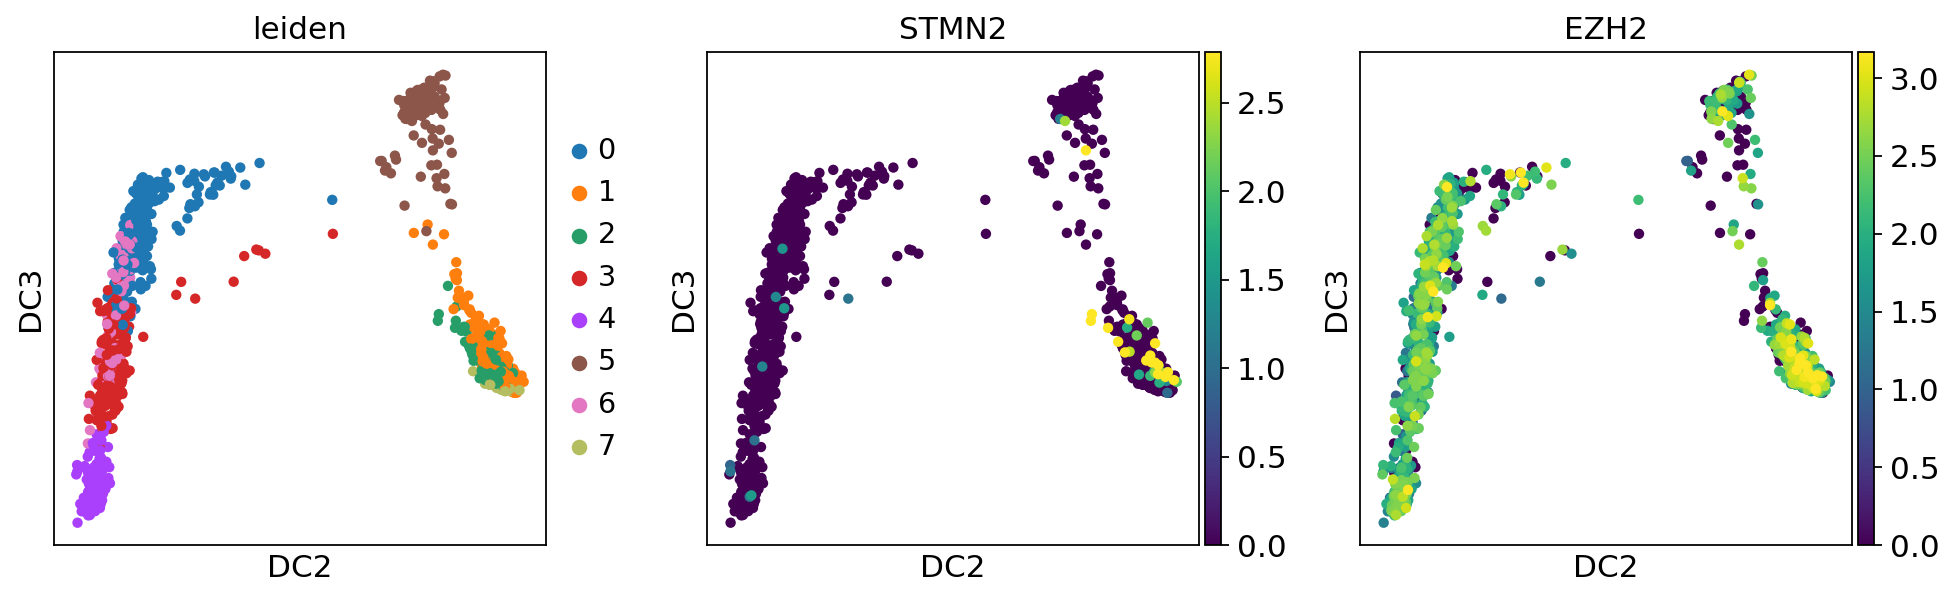

In [47]:
sc.pl.diffmap(adata,color=["leiden",'STMN2','EZH2'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [48]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: pericyte, endothelial, ExcDeepLayer, etc.


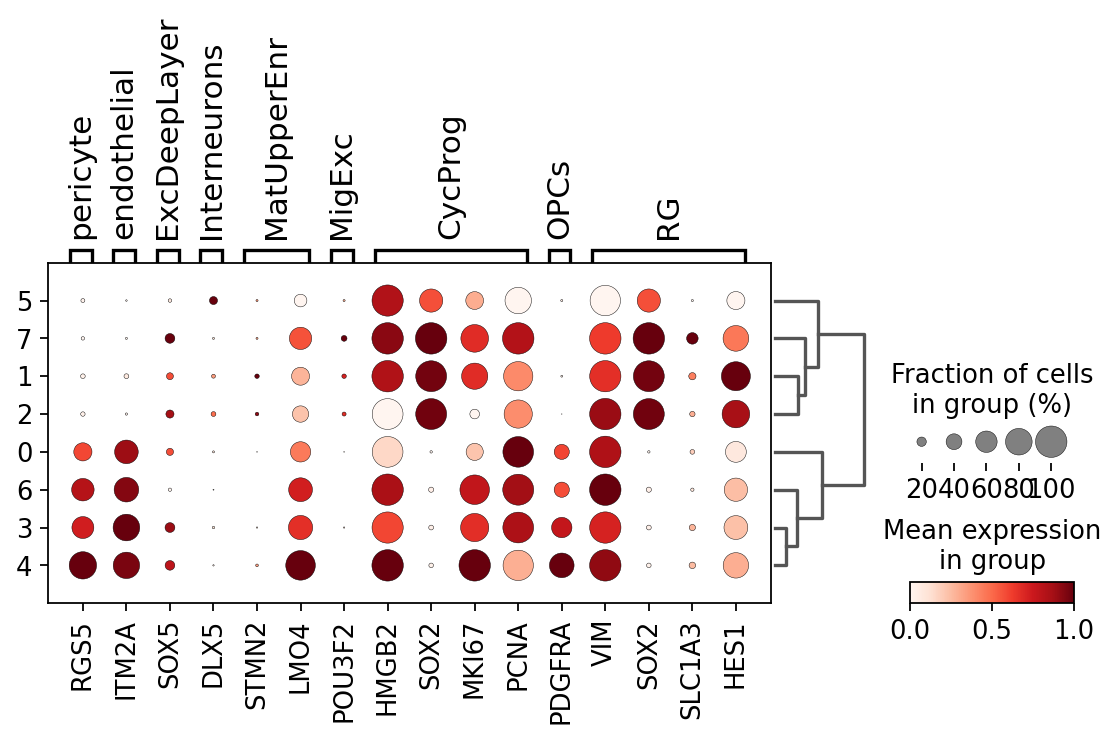

In [49]:
geschwind_ext = {
  'pericyte' : ['RGS5'],
  'endothelial' : ['ITM2A'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX5'],
  'MatUpperEnr' : ['STMN2','LMO4'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PDGFRA'],
  'RG' : ['VIM','SOX2','SLC1A3','HES1']
}
 
sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [50]:
cluster2annotation = {
    "0": "endothelial", "1": "RG","2":"RG", "3": "endothelial",
    "4": "endothelial", "5" : "RG", "6":"endothelial",
    '7': 'RG'
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [51]:
cluster2annotation = {
   "0": "endothelial", "1": "vRG","2":"vRG", "3": "endothelial",
    "4": "endothelial", "5" : "vRG", "6":"endothelial",
    '7': 'vRG'
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [52]:
new_cluster_names = [
    '0/endo', '1/RG',
    '2/RG', '3/endo',
    '4/endo','5/RG', '6/endo', '7/RG']
adata.rename_categories('leiden', new_cluster_names)

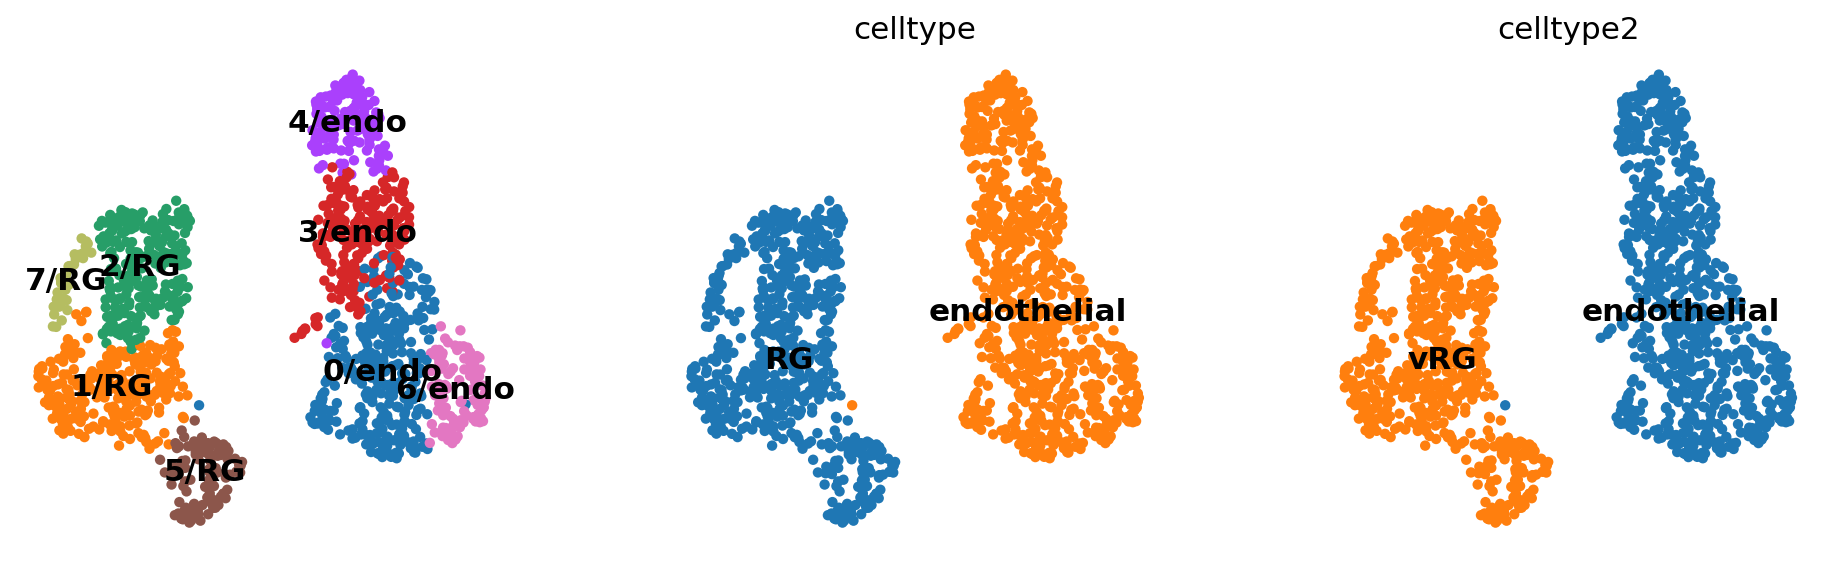

In [53]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

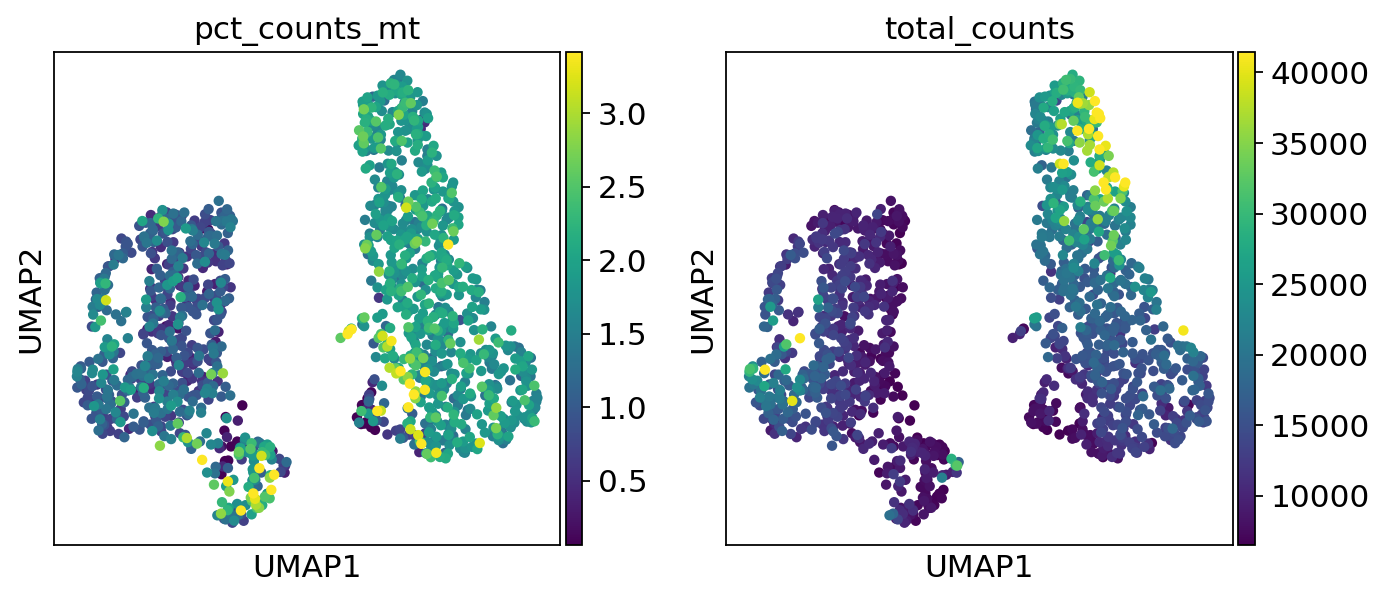

In [54]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [55]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99682534 0.9754985  0.9712987  0.9617903  0.9532212
     0.9356672  0.93128043 0.9228877  0.91909087 0.9044036  0.89440185
     0.8914522  0.888701   0.8837802 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [56]:
adata.obs.leiden.value_counts()

0/endo    303
1/RG      255
2/RG      232
3/endo    207
4/endo    130
5/RG      111
6/endo    100
7/RG       38
Name: leiden, dtype: int64

In [57]:
adata_check = adata[~adata.obs.celltype.isin(['endothelial'])].copy()

In [58]:
sc.tl.diffmap(adata_check)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9769667  0.9630728  0.9365963  0.92460847 0.8984983
     0.89083606 0.8848395  0.8666364  0.8624084  0.8426413  0.8332971
     0.80862576 0.8011644  0.79230237]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


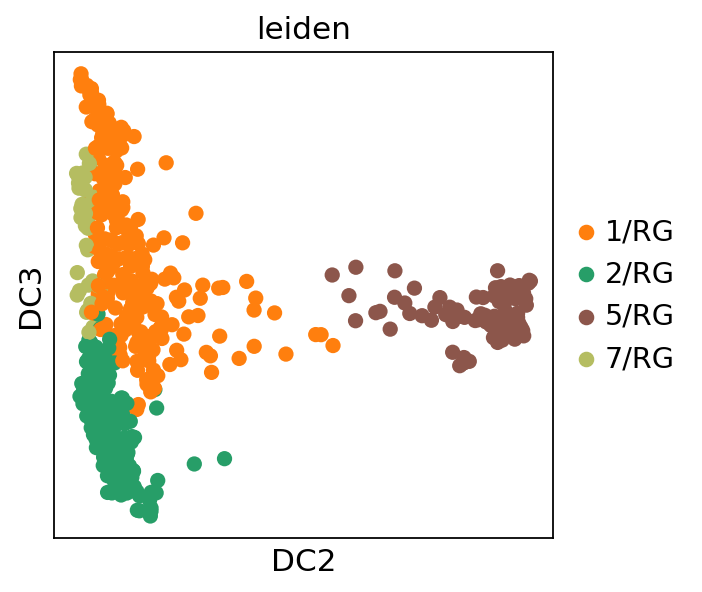

In [59]:
sc.pl.diffmap(adata_check,color="leiden",dimensions=(1,2))

In [60]:
adata.obs.leiden

AAACGGGAGAGAACAG-1      2/RG
AAACGGGCAGTGAGTG-1      7/RG
AAACGGGCATCCTTGC-1    6/endo
AAACGGGGTCAAAGCG-1      1/RG
AAACGGGGTCACTTCC-1    3/endo
                       ...  
TTTGGTTGTTGAACTC-1      5/RG
TTTGGTTTCGCTAGCG-1      7/RG
TTTGTCAAGGTCGGAT-1      7/RG
TTTGTCAAGTGGGCTA-1    6/endo
TTTGTCACAGGGAGAG-1      2/RG
Name: leiden, Length: 1376, dtype: category
Categories (8, object): ['0/endo', '1/RG', '2/RG', '3/endo', '4/endo', '5/RG', '6/endo', '7/RG']

In [61]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [63]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/CS14_02_20240208_v1.h5ad')

In [3]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS14_02_20240208_v1.h5ad")

In [4]:
adata.obs['stage'] = 'CS14'

In [5]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/CS14_02_20240208_v1.h5ad')